# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [2]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [3]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 556 samples from 4 classes.


# Exploratory Data analysis
## Class distribution


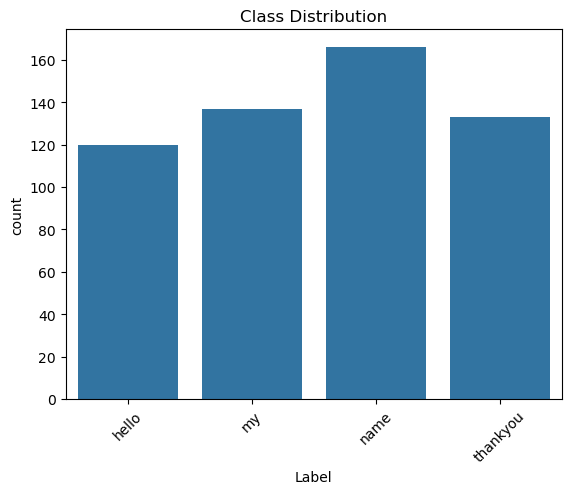

In [4]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 388, Val: 84, Test: 84


# Build model

In [7]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,124 (801.27 KB)

 Trainable params: 205,124 (801.27 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4190 - loss: 1.2051

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.4218 - loss: 1.1997 - val_accuracy: 0.7143 - val_loss: 0.6292
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7071 - loss: 0.6868

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7085 - loss: 0.6845 - val_accuracy: 0.9286 - val_loss: 0.2633
Epoch 3/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8790 - loss: 0.3818

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8786 - loss: 0.3823 - val_accuracy: 0.9048 - val_loss: 0.2063
Epoch 4/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9151 - loss: 0.2518

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9149 - loss: 0.2534 - val_accuracy: 0.9762 - val_loss: 0.0597
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9577 - loss: 0.1509 - val_accuracy: 0.9643 - val_loss: 0.1549
Epoch 6/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9641 - loss: 0.1992

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9647 - loss: 0.1951 - val_accuracy: 0.9881 - val_loss: 0.0533
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9856 - loss: 0.0583 - val_accuracy: 0.9881 - val_loss: 0.0577
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9058 - loss: 0.2364 - val_accuracy: 0.9405 - val_loss: 0.1149
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9858 - loss: 0.0770 - val_accuracy: 0.9643 - val_loss: 0.1474
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9763 - loss: 0.0835 - val_accuracy: 0.9643 - val_loss: 0.1029
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9712 - loss: 0.1116 - val_accuracy: 0.8571 - val_loss: 0.7130
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9597 - loss: 0.2012

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9604 - loss: 0.1978 - val_accuracy: 1.0000 - val_loss: 0.0159
Epoch 13/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9763 - loss: 0.0721

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9763 - loss: 0.0724 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9847 - loss: 0.0816 - val_accuracy: 0.9524 - val_loss: 0.1680
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9132 - loss: 0.2595 - val_accuracy: 0.9167 - val_loss: 0.1620
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9509 - loss: 0.1193 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 17/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9903 - loss: 0.0471 - val_accuracy: 0.9881 - val_loss: 0.0120
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9907 - loss: 0.0341 - val_accuracy: 0.9762 - val_loss: 0.0294
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0254

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 9.9897e-04
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9978 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9991 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9985 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9943 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9957 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9826 - loss: 0.0525 - val_accuracy: 0.9643 - val_loss: 0.2143
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9690 - loss: 0.2424 - val_accuracy: 0.9881 - v

# Plot training history

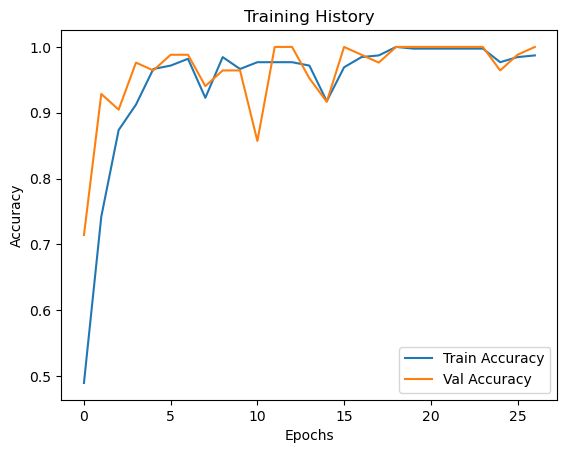

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9725 - loss: 0.2672
Test Accuracy: 0.9762
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      0.94      0.97        18
          my       1.00      0.95      0.98        21
        name       0.93      1.00      0.96        25
    thankyou       1.00      1.00      1.00        20

    accuracy                           0.98        84
   macro avg       0.98      0.97      0.98        84
weighted avg       0.98      0.98      0.98        84



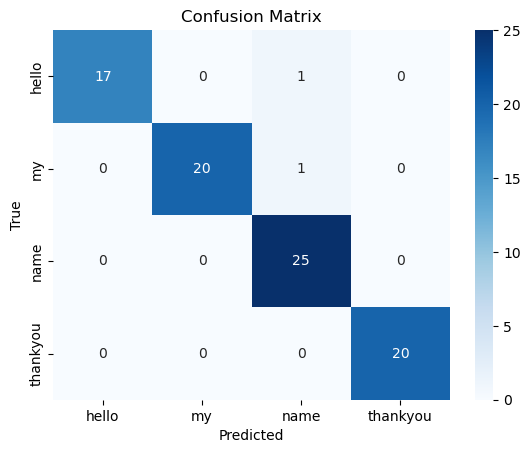

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [11]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
